1. 
First need to read in the weekly returns for the 9 specified stocks from the period Jan 2005 - Dec 2009.
Stocks are Wells Fargo, JP Morgan, Apple, Microsoft, Google, IBM, Walmart, AIG, and GE.

In [205]:
#Need to run this command at anaconda prompt: "$ pip3 install yfinance"
import arch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf


In [197]:
#spx is the sp500
data = yf.download(
        tickers = 'wfc jpm aapl msft googl ibm wmt aig ge spy', 
        start = "2005-01-01", 
        end = "2008-12-31",
        interval = "1wk",
        group_by = 'ticker',
        threads = True)

[*********************100%***********************]  10 of 10 completed


Now lets turn this multi-index df into a regular df and looking only at AdjClose which we'll use to calculate 
the logreturn values weekly. Also, periodic NA values result from yfinance throwing in random non week ending datapoints, probably resulting from choosing Jan 1st 2005 as the starting point which was a Saturday. So, lets drop those and then calculate log returns. $$ \textbf{Beware, running this cell twice kills the structure, so if you do, you need to run the yf.download cell again before moving on.} $$

In [198]:
AdjClose = data.iloc[:, data.columns.get_level_values(1) == 'Adj Close']
processed = AdjClose.dropna()
processed.columns = processed.columns.droplevel(1)  #turns columns from multi-index to normal index
logRet = np.log(processed)
logRet = logRet.diff()
logRet = logRet.dropna()
logRet.head()

,MSFT,SPY,AIG,WFC,WMT,AAPL,IBM,GE,GOOGL,JPM
Date,,,,,,,,,,
2005-01-08,-0.020838,-0.001690,-0.021538,-0.024094,0.000000,0.013625,-0.017696,-0.013423,0.031083,-0.006761
2005-01-15,-0.018158,-0.012425,-0.000303,-0.009437,-0.018318,0.004123,-0.018447,-0.011041,-0.060237,-0.025718
2005-01-22,0.020452,0.005551,-0.003939,0.006631,-0.011002,0.048323,0.005506,0.017495,0.010882,0.004062
2005-01-29,0.005333,0.023564,0.024892,0.007572,0.019455,0.063626,0.017290,0.013889,0.071071,0.018477
2005-02-05,-0.013387,0.004482,0.079678,-0.003417,-0.025769,0.029619,-0.012886,-0.000552,-0.086638,-0.005587


2. 
Conduct the NPEB analysis on the individual returns in order to generate the return distribution as well as the covariance relationships.

Solve $\textbf{w}_{\lambda}^{(n)} (\eta) := argmin_{w:w^{T}1 = 1}E[E[(\phi(W) - \eta W | F_{n}]] $ using ideas from NPEB, i.e. the equation derived from (2.5):

$$ \textbf{w}(\eta) = \frac{\textbf{V}_{n}^{-1} \textbf{1}}{\textbf{1}^{T} \textbf{V}_{n}^{-1} \textbf{1}}  + \frac{\eta}{2\lambda} \textbf{V}_{n}^{-1} (\textbf{ \mu}_{n} - \frac{\textbf{ \mu}_{n}^{T} \textbf{V}_{n}^{-1} \textbf{1}}{\textbf{1}^{T} \textbf{V}_{n}^{-1} \textbf{1}} \textbf{1} ) $$

and via the text, we know that $\mu_{n}$ and $\textbf{V}_{n}$ are 

$$ \mu_{n} = (\hat{\beta}_{1}^{T} x_{1,n-1}, ... , \hat{\beta}_{m}^{T} x_{m,n-1} )^{T} $$

$$ \textbf{V}_{n} = \textbf{\mu}_{n} \textbf{\mu}_{n}^{T} + (\hat{s}_{i,n} \hat{s}_{j,n} \hat{\sigma}_{i,j}) $$

Then, search for $\eta$ by minimizing (2.11) for given $\lambda$, followed by searching for $\lambda$ over a grid to minimize (maximize right?) the information ratio: 
$$E_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b}) / \sqrt{(Var_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b})} $$

In [199]:
#Lets first find the prior distribution via MLE estimators (practice of NPEB). 
#First, we can model the returns using two factors and a constant term, and then we can model the error as GARCH(1,1)

iterator = 0
beta = dict()

X = logRet.shift(1) #we'll be using prevoius observations
for col in logRet.columns:
    if col == 'SPY':
        continue
    col_1 = X.columns.get_loc('SPY')
    col_2 = X.columns.get_loc(col)
    x = X.iloc[1:, [col_1,col_2]]
    x = sm.add_constant(x)
    y = logRet.iloc[1:, logRet.columns == col].to_numpy().reshape(-1,1)
    model = sm.OLS(y, x)
    beta[col] = model.fit()
    iterator = iterator + 1
    

In [200]:
print(beta[logRet.columns[0]].params)

const   -0.001452
SPY     -0.112463
MSFT    -0.137880
dtype: float64


In [201]:
#Now that we have our parameters, lets calculate mu_n and our residuals so that we may perform arch on them

muRange = np.arange(start=0,stop=len(logRet))
mu = np.empty((len(logRet), numAssets))
res = np.empty((len(logRet), numAssets))
j = 0


#I believe in order to use these estimates for the actual study, we'll need to use a sliding window, and
#calculate these parameters at each time step within the sliding window

#Take the rest of this work to just setting up a framework for calulating these quantities

for col in logRet.columns:
    if col == 'SPY':
        continue
    col_1 = X.columns.get_loc('SPY')
    col_2 = X.columns.get_loc(col)
    for i in range(1, len(logRet)):
        data = np.array([1, X.iloc[i, col_1], X.iloc[i, col_2]])
        mu[i, j] = np.transpose(beta[col].params)@data
        res[i,j] = logRet[col].iloc[i] - mu[i,j]
        
    j = j+1
    

In [202]:
#Lets get rid of the first rows as they are meaningless
mu = np.delete(mu, (0), axis = 0)
res = np.delete(res, (0), axis = 0)

In [215]:
#Now we can model our residuals as a GARCH(1,1) process
res

iVol = list()
for m in range(0,res.shape[1]):
    #Note, i could pass exogenous regressors to this constructor via x = X as defined before
    
    iModel = arch.arch_model(res[:, m], mean = 'Zero', dist = 't', rescale = True)
    iModelFit = iModel.fit()
    iVol.append(iModelFit.params)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 320.6335515121691
Iteration:      2,   Func. Count:     13,   Neg. LLF: 66.45816976746192
Iteration:      3,   Func. Count:     23,   Neg. LLF: 274.6831825188227
Iteration:      4,   Func. Count:     29,   Neg. LLF: 49.17609388937803
Iteration:      5,   Func. Count:     34,   Neg. LLF: 228.0991575790768
Iteration:      6,   Func. Count:     40,   Neg. LLF: 50.65923664626112
Iteration:      7,   Func. Count:     46,   Neg. LLF: 52.019532397572945
Iteration:      8,   Func. Count:     52,   Neg. LLF: 211.4099962950864
Iteration:      9,   Func. Count:     58,   Neg. LLF: 48.62676063746559
Iteration:     10,   Func. Count:     63,   Neg. LLF: 48.61415056617668
Iteration:     11,   Func. Count:     68,   Neg. LLF: 48.60431192201887
Iteration:     12,   Func. Count:     73,   Neg. LLF: 48.602589599415005
Iteration:     13,   Func. Count:     78,   Neg. LLF: 48.602469671635006
Iteration:     14,   Func. Count:     83,   Neg. LLF: 48.6024

Iteration:      7,   Func. Count:     45,   Neg. LLF: 90.81102200916199
Iteration:      8,   Func. Count:     50,   Neg. LLF: 90.80608823476538
Iteration:      9,   Func. Count:     55,   Neg. LLF: 90.80060893806717
Iteration:     10,   Func. Count:     60,   Neg. LLF: 90.80050857745887
Iteration:     11,   Func. Count:     65,   Neg. LLF: 90.80050690055182
Iteration:     12,   Func. Count:     69,   Neg. LLF: 90.80050690055185
Optimization terminated successfully    (Exit mode 0)
            Current function value: 90.80050690055182
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12


In [209]:
#Assume the following are inside the for loop where we were filling in mu and res
def s(params, data):
    ret = params[0] + params[1]*data[0]**2 + params[2]*data[1]**2
    return ret

sample_cov = np.cov(res[0])
for i in range(0, numAssets):
    for j in range(0, numAssets):
        
        V_n[i,j] = np.sqrt(s(iVol[i].params, dataI))*np.sqrt(s(iVol[j].params, dataJ))*sample_cov[i,j]
        V_n[i,j] += mu[i,i]*mu[i,j]

207


3. 
Calculate the Expected Shortfall (cVARa) estimates for the data at each time point, where CVaR is the convex function 

4. 
Calculate the optimal portfolio weights via grid search, optimization, and using the previous n = 120 weeks in order to construct the subsequent week.

In [66]:
risk_lambda = [2**i for i in range(-3,7)]
print(risk_lambda)

[0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


5. 
Using these dynamic portfolio weights, model the cumulative returns for the period and compare them to plug-in portfolio.

In [192]:
#Lets first find the plug-in returns using the same idea with a sliding window

def optimalWeight(retMean, retCov, targetReturn, riskFree):
    inverseCov = np.linalg.inv(retCov)
    riskAdjMean = np.subtract(retMean, riskFree)
    one = np.ones((len(retMean),1))
    
    A = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@one)
    B = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@riskAdjMean)
    C = np.transpose(one)@inverseCov@one
    D = B*C - A**2

    numerator = B*inverseCov@one - A*inverseCov@riskAdjMean
    numerator += targetReturn*(C*inverseCov@riskAdjMean - A*inverseCov@one)
    optimalWeights = numerator * (1/D)

    return optimalWeights

In [193]:
windowSize = 120
rf = 0
numAssets = 9
maxRet = 5

#In order to find the plug-in portfolio that returns the highest information ratio, we'll need to do some
#grid searching

mu = np.linspace(0.1, maxRet, 51)

plugInReturn = []
riskFree = np.full((numAssets,1), rf)


for i in range(10, len(logRet)):   #algo unstable for low history, so we start at n = 10
    leftIndex = max(0, i - windowSize)
    sampleMean = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].mean(axis = 0)
    sampleCov = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].cov()
    periodRet = logRet.iloc[i, logRet.columns != 'SPY']
    marketRet = logRet.iloc[i, logRet.columns == 'SPY']
        
    sampleMeanMatrix = sampleMean.to_numpy()
    sampleMeanMatrix = sampleMeanMatrix.reshape((numAssets,1))
    sampleCovMatrix = sampleCov.to_numpy()
    periodRetMatrix = periodRet.to_numpy()
    
    InfoRatio = -10000000  #just need it to be a value that no other value will fail to be a max
    maxWeight = np.ones((numAssets,1))
    
    for j in mu:
        
        optimalweights = optimalWeight(sampleMeanMatrix, sampleCovMatrix, j, riskFree)
        expectedReturn = np.ndarray.item(np.transpose(optimalweights)@sampleMeanMatrix)
        expectedVariance = np.ndarray.item(np.transpose(optimalweights)@sampleCovMatrix@optimalweights)
        temp = (expectedReturn - marketRet.values[0]) / np.sqrt(expectedVariance)
        if temp > InfoRatio:
            maxWeight = optimalweights
            
    iRet = np.transpose(maxWeight)@periodRetMatrix 
    plugInReturn.append(np.ndarray.item(iRet) - marketRet.values[0])



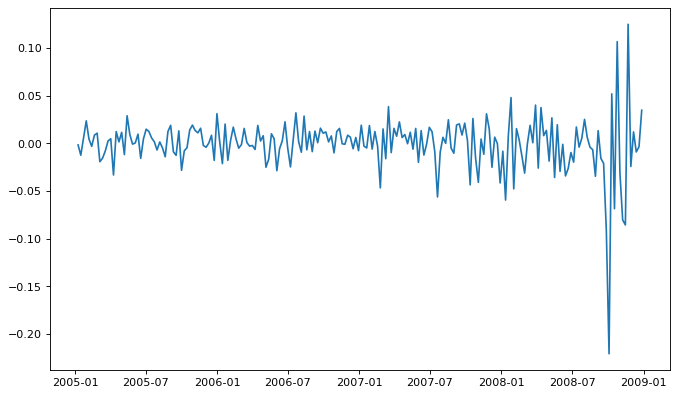

In [216]:
plt.figure(figsize=(10,6), dpi = 80)

cumulative = []
cumsum = 0
for i in plugInReturn:
    cumsum += i
    cumulative.append(cumsum)

#plt.plot(plugInReturn)
#plt.plot(cumulative)
plt.plot(logRet['SPY'])


This is obviously so wildly outperforming the index so something is wrong with the code. My guess is that we get a massive jump in perfomance in what seems to be around the 2007 time period, and we have huge short positions in the portfolio that generate massive returns. Need to take a look at what's going wrong for the plug-in portfolio. 